In [1]:
import gdown
import torch
import rpy2
import scipy
import logging
import warnings
import anndata
import anndata2ri
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import decoupler as dc
import scarches as sca
import scrublet as scr
import decoupler as dc
from scipy import sparse
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from gsva_prep import prep_gsva
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from typing import Optional, Union
from matplotlib.pyplot import rcParams
from functions import pathway_analyses
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

 captum (see https://github.com/pytorch/captum).
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/Users/temitopeleke/miniforge3/envs/scRNA_seq_meta_analysis/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/scRNA_seq_meta_analysis/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                     22.0.0
PIL                         9.2.0
absl                        NA
anndata2ri                  1.1
appnope                     0.1.2
asttokens                   NA
astunparse                  1.6.3
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boto3                       1.26.32
botocore                    1.29.32
bottleneck                  1.3.5
brotli                      NA
bs4                         4.11.1
certifi                     2022.09.24
cffi                        1.15.1
charset_normalizer          2.0.4
chex                        0.1.5
cloudpickle                 2.2.0
colorama                    0.4.4
contextlib2                 NA
cryptography                38.0.1
cycler                      0.10.0
cython_runtime              NA
dask                        2022.11.0
dateutil                    2.8.2
debu

# **Table of contents**:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Systematic differential analysis of gene expression</a>

## **1. Reading in the data**

### **Prepare data**

Now, we load the preprocessed and annotated data for differential pathway analysis.

Make sure the anndata has the count data in either `.layers` or in `.X`. if count data is not in `.layers` it will be assumed that `.X ` contains the counts

In [4]:

adata_sample = {}
batch_keys = ['allen_mtg', 'leng_etc', 'leng_sfg']
sample_id = {"allen_mtg": 'individualID',
             "leng_etc": 'PatientID',
             "leng_sfg": 'PatientID'}

cell_types = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC', 'Endothelial']


for key in batch_keys:
    
    print('----------------------------')
    print(f'Fetching {key.upper()} data')
    print('----------------------------')

    adata_sample[key] = sc.read_h5ad(f'../data/processed/{key}/{key}_annotated_anndata.h5ad')
    metadata = pd.read_csv(f'../data/raw/{key}/{key}_metadata.csv', encoding_errors='ignore')
    metadata_map = dict(zip(metadata[sample_id[key]].astype(str), metadata['pathology.group']))

    adata_sample[key].obs['study'] = key
    adata_sample[key].obs['pathology.group'] = adata_sample[key].obs[sample_id[key]].map(metadata_map)

    adata_sample[key].obs_names_make_unique()
    adata_sample[key].var_names_make_unique()
    adata_sample[key].X = adata_sample[key].layers['counts'].copy()

    del adata_sample[key].obsm, adata_sample[key].varm, adata_sample[key].uns, adata_sample[key].obsp

    print(adata_sample[key])

----------------------------
Fetching ALLEN_MTG data
----------------------------
AnnData object with n_obs × n_vars = 104349 × 17950
    obs: 'ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes', 'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId', 'synapseURL', 'dataFileMD5Hex', 'assay_x', 'consortium', 'dataSubtype', 'dataType', 'fileFormat', 'grant', 'individualID_x', 'isModelSystem', 'isMultiSpecimen', 'isMultiome', 'libraryPrep', 'nucleicAcidSource_x', 'organ_x', 'platform', 'readLength', 'resourceType', 'runType', 'sex_x', 'species_x', 'specimenID', 'study', 'tissue_x', 'path', 'error', 'individualID_y', 'specimenIdSource', 'organ_y', 'tissue_y', 'BrodmannArea', 'sampleStatus', 'tissueWeight', 'tissueVolume', 'nucleicAcidSource_y', 'cellType', 'fastingState', 'isPostMortem', 'samplingAge', 'samplingAgeUnits', 'visitNumber', 'assay_y', 'individualID', 'dataset', 'individualIdSource', 'species_y', 'sex_y', 'race', 'ethnicity', 'yearsEducation', 'ageDeath'

In [5]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

# **Make reference and do preprocessing**

In [6]:
ref_adatas = []
query_adatas = []

for key in batch_keys:
    
    print('---------------------------------------------------')
    print(f'Fetchin reference and query from {key.upper()} data')
    print('---------------------------------------------------')

    ref_adatas.append(adata_sample[key][adata_sample[key].obs['pathology.group']=='no'])
    query_adatas.append(adata_sample[key][adata_sample[key].obs['pathology.group']!='no']) 
 
         
adata_ref = anndata.concat(ref_adatas, join='outer')
adata_query = anndata.concat(query_adatas, join='outer')

del ref_adatas, query_adatas


print('-------------------')
print(f'Reference data')
print('-------------------')
print(adata_ref)



print('-------------------')
print(f'Query data')
print('-------------------')
print(adata_query)


---------------------------------------------------
Fetchin reference and query from ALLEN_MTG data
---------------------------------------------------
---------------------------------------------------
Fetchin reference and query from LENG_ETC data
---------------------------------------------------
---------------------------------------------------
Fetchin reference and query from LENG_SFG data
---------------------------------------------------
-------------------
Reference data
-------------------
AnnData object with n_obs × n_vars = 93530 × 18168
    obs: 'ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes', 'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId', 'synapseURL', 'dataFileMD5Hex', 'assay_x', 'consortium', 'dataSubtype', 'dataType', 'fileFormat', 'grant', 'individualID_x', 'isModelSystem', 'isMultiSpecimen', 'isMultiome', 'libraryPrep', 'nucleicAcidSource_x', 'organ_x', 'platform', 'readLength', 'resourceType', 'runType', 'sex_x', 'species_x',

Read the Reactome annotations, make a binary matrix where rows represent gene symbols and columns represent the terms, and add the annotations matrix to the reference dataset. The binary matrix of annotations is stored in adata.varm['I']. Note that only terms with minimum of 12 genes in the reference dataset are retained.

**Function to read a GMT file and extract the gene sets:**

In [7]:
def read_gmt_file(file_path):
    gene_sets = {}
    with open(file_path, 'r') as file:
        for line in file:
            data = line.strip().split('\t')
            gene_set_name = data[0]
            genes = data[2:]
            gene_sets[gene_set_name] = genes
    return gene_sets

def write_gmt_file(pathway_genes, file_path):
    with open(file_path, 'w') as file:
        for pathway, genes in pathway_genes.items():
            gene_list = '\t'.join(genes)
            line = f"{pathway}\t\t{gene_list}\n"
            file.write(line)


Get overlapping pathways

In [9]:
overlap_pathways = pd.read_csv("../results/ad_vs_no/ad_vs_no_pathway_overlap.csv")['pathway'].to_list()

In [10]:
# empty dictionary to store the merged gene sets:
merged_gene_sets = {}

# Iterate over each GMT file and merge its gene sets into the merged_gene_sets dictionary:

gmt_files = [f'../results/gsva/{study}/{cell_type}/gs.gmt' for study in batch_keys for cell_type in cell_types]  # Replace with your file paths

for gmt_file in gmt_files:
    gene_sets = read_gmt_file(gmt_file)
    for gene_set_name, genes in gene_sets.items():
        if gene_set_name in overlap_pathways:
            gene_set_name = '_'.join([name.upper() for name in gene_set_name.split(' ')[:-1]])
            if gene_set_name in merged_gene_sets:
                merged_gene_sets[gene_set_name].extend(genes)
            else:
                merged_gene_sets[gene_set_name] = genes

gmt_file_path = '../results/gsva/merged_gene_sets.gmt'
write_gmt_file(merged_gene_sets, gmt_file_path)




In [11]:
sca.utils.add_annotations(adata_ref, gmt_file_path, min_genes=12, clean=False)

Remove all genes which are not present in the Reactome annotations.

In [12]:
adata_ref._inplace_subset_var(adata_ref.varm['I'].sum(1)>0)

In [13]:
len(adata_ref.uns['terms'])

527

For a better model performance it is necessary to select HVGs. We are doing this by applying the `scanpy.pp` function `highly_variable_genes()`. The `n_top_genes` is set to `5000` here. This is beacuse this is a more complicated dataset so we set a higher number of genes to capture more diversity in the data.

In [14]:
sc.pp.normalize_total(adata_ref)
sc.pp.log1p(adata_ref)

normalizing counts per cell
    finished (0:00:00)


In [15]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=2000,
    batch_key="study",
    subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Filter out all annotations (terms) with less than 12 genes.

In [16]:
select_terms = adata_ref.varm['I'].sum(0)>12
adata_ref.uns['terms'] = np.array(adata_ref.uns['terms'])[select_terms].tolist()
adata_ref.varm['I'] = adata_ref.varm['I'][:, select_terms]

Filter out genes not present in any of the terms after selection of HVGs.

In [17]:
adata_ref._inplace_subset_var(adata_ref.varm['I'].sum(1)>0)

Put the counts data back to adata.X

In [18]:
adata_ref.X = adata_ref.layers["counts"].copy()

## **Create expiMap model and train it on reference dataset**

In [19]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata_ref,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1498 256 3
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 160
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  160 0 0 3 1498
	with hard mask.
Last Decoder layer: softmax


Set the `ALPHA` hyperparameter. This `regulates the strength of group lasso regularization of annotations (terms)`. 

Higher value means that a larger number of latent variables corresponding to annotations will be deactivated during training depending on their contribution to the reconstruction loss.

See also https://docs.scarches.org/en/latest/training_tips.html for the recommendation on hyperparameter choice.

In [20]:
ALPHA = 0.7

In [21]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 5,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

intr_cvae.train(
    n_epochs= 70,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 708.3156625116 - epoch_recon_loss: 684.2543513057 - epoch_kl_loss: 69.7429292905 - val_loss: 1051.7551673683 - val_recon_loss: 1021.3063733900 - val_kl_loss: 88.2573638091723
Saving best state of network...
Best State was in Epoch 69


In [22]:
MEAN = False

Plot the latent space of the reference.

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)


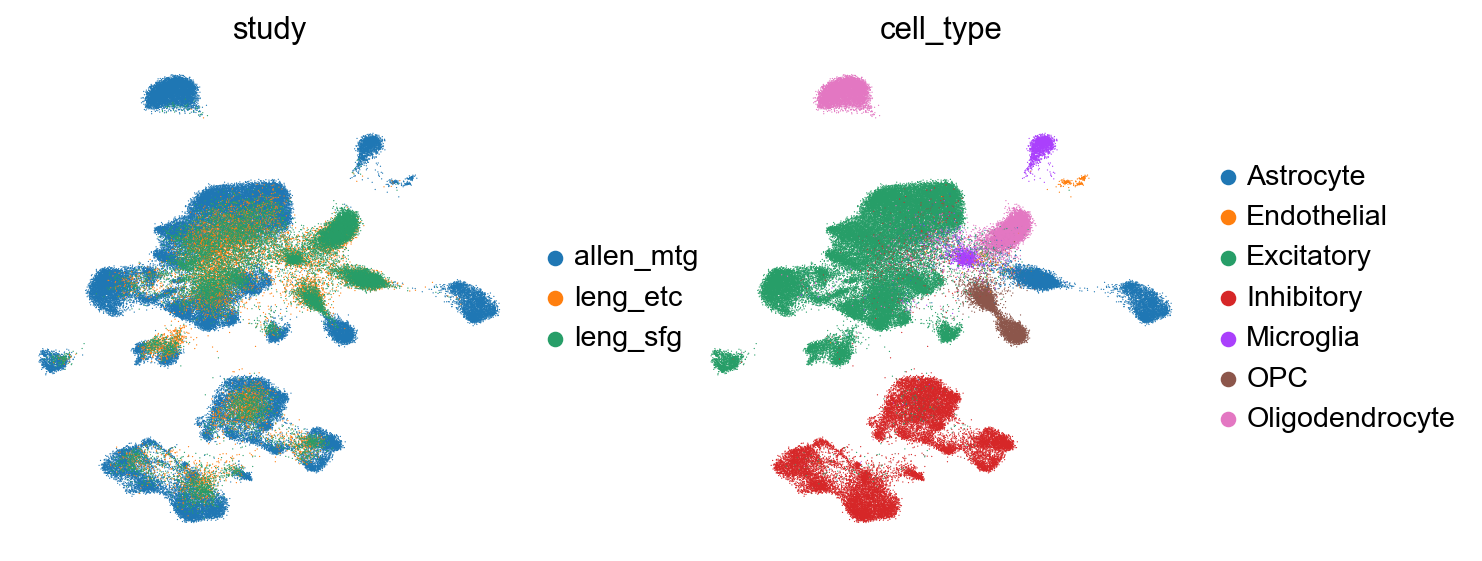

In [23]:
adata_ref.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

sc.pp.neighbors(adata_ref, use_rep='X_cvae')
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color=['study', 'cell_type'], frameon=False)

## **Initlizling the model for query training**

In [24]:
adata_query.uns['terms'] = adata_ref.uns['terms'].copy()

In [25]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(adata_query, intr_cvae)

Query data contains expression data of  16670  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 114140 × 1498
    obs: 'ID', 'name', 'versionNumber', 'contentType', 'dataFileSizeBytes', 'createdBy', 'createdOn', 'modifiedBy', 'modifiedOn', 'parentId', 'synapseURL', 'dataFileMD5Hex', 'assay_x', 'consortium', 'dataSubtype', 'dataType', 'fileFormat', 'grant', 'individualID_x', 'isModelSystem', 'isMultiSpecimen', 'isMultiome', 'libraryPrep', 'nucleicAcidSource_x', 'organ_x', 'platform', 'readLength', 'resourceType', 'runType', 'sex_x', 'species_x', 'specimenID', 'study', 'tissue_x', 'path', 'error', 'individualID_y', 'specimenIdSource', 'organ_y', 'tissue_y', 'BrodmannArea', 'sampleStatus', 'tissueWeight', 'tissueVolume', 'nucleicAcidSource_y', 'cellType', 'fastingState', 'isPostMortem', 'samplingAge', 'samplingAgeUnits', 'visitNumber', 'assay_y', 'individualID', 

In [26]:
q_intr_cvae.train(n_epochs=70, 
                  alpha_epoch_anneal=100, 
                  weight_decay=0., 
                  alpha_kl=0.1, 
                  seed=2020, 
                  use_early_stopping=True)

 |████████████████████| 100.0%  - val_loss: 656.7923699273 - val_recon_loss: 649.0730678982 - val_kl_loss: 111.8739496867
Saving best state of network...
Best State was in Epoch 0


Save your model

In [28]:
q_intr_cvae.save('../models/expimap_query_allen_leng', overwrite=True)

## **Get latent representation of reference + query dataset**

In [29]:
ref_query = sc.AnnData.concatenate(adata_ref, adata_query, batch_key='batch_join', uns_merge='same')

In [30]:
ref_query.obsm['X_cvae'] = q_intr_cvae.get_latent(ref_query.X, ref_query.obs['study'], mean=MEAN, only_active=True)

In [31]:
sc.pp.neighbors(ref_query, use_rep='X_cvae')
sc.tl.umap(ref_query)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:36)


In [32]:
ref_query.obs['condition_joint'] = ref_query.obs['pathology.group'].astype(str)

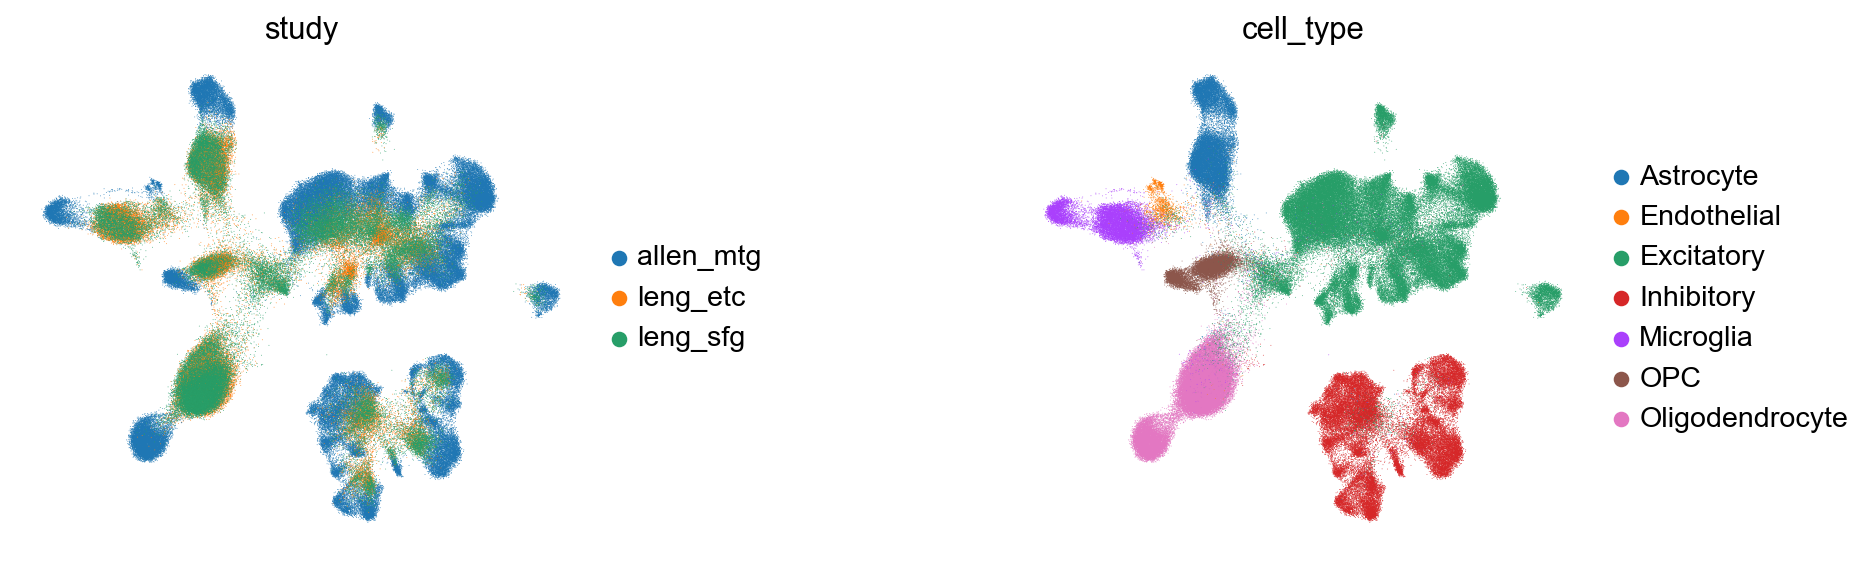

In [33]:
sc.pl.umap(ref_query, color=['study', 'cell_type'], frameon=False, wspace=0.6)

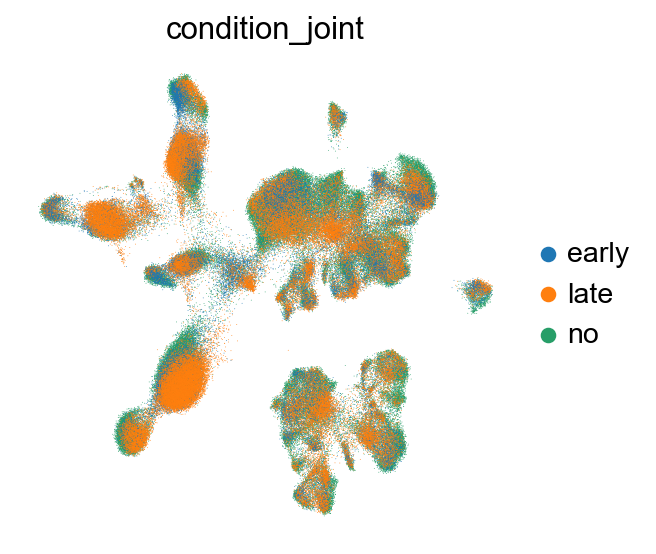

In [34]:
sc.pl.umap(ref_query, color='condition_joint', frameon=False, wspace=0.6)

Calculate directions of upregulation for each latent score and put them to ref_query.uns['directions'].

In [35]:
q_intr_cvae.latent_directions(adata=ref_query)

Do gene set enrichment test for condition in reference + query using Bayes Factors.

In [36]:
q_intr_cvae.latent_enrich(groups='condition_joint', comparison='no', use_directions=True, adata=ref_query)

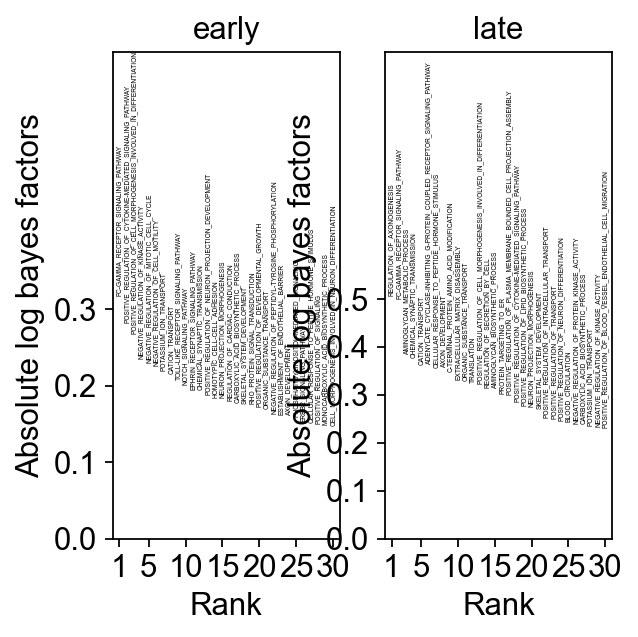

In [40]:
fig = sca.plotting.plot_abs_bfs(ref_query, yt_step=0.1, scale_y=2.0, fontsize=3)